In [2]:
# Import PyTorch libraries
import torch
from torch import nn

# Import visualization library
import matplotlib.pyplot as plt

# Verify PyTorch version
torch.__version__

'1.12.1+cu113'

In [3]:
# Check to see if we have a GPU to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device))

# Print the name of the cuda device, if detected
if device=='cuda':
    print (torch.cuda.get_device_name(device=device))

A cpu device was detected.


##  Download and Prepare our Dataset


In [5]:
# Use Pandas to do our dataprocessing on the dataset
# Download the dataset
import pandas as pd
url = 'https://raw.githubusercontent.com/LeakyAI/FirstNeuralNet/main/lemons.csv'
df = pd.read_csv(url)

# Explore the first 10 rows of the dataset
df.head(10)



,Weekend,Sunny,Warm,BigSign,Price,NumberSold
0,1,0,0,1,9,71
1,1,1,1,0,10,137
2,0,1,0,0,10,0
3,1,0,0,1,6,107
4,1,0,0,1,8,80
5,1,1,0,0,6,110
6,1,1,1,0,8,167
7,0,0,1,1,8,0
8,1,0,1,0,8,124
9,1,1,0,0,7,95


In [6]:
# Check the size/shape of our dataset
df.shape

(365, 6)

### Creating Inputs and Outputs for Training the Neural Network

The data has been collected in a table with the following columns:  

<pre> Weekend Sunny Warm BigSign Price NumberSold</pre>



In [7]:
# Calculate the mean and standard deviation of price
# Standardize numSold
priceMean = df['Price'].mean()
priceStd = df['Price'].std()
df['Price'] = (df['Price']-priceMean)/priceStd

# Calculate the mean and standard deviation of the numSold column, then standardize numSold
numSoldMean = df['NumberSold'].mean()
numSoldStd = df['NumberSold'].std()
df['NumberSold'] = (df['NumberSold']-numSoldMean)/numSoldStd

In [8]:
df.head()

,Weekend,Sunny,Warm,BigSign,Price,NumberSold
0,1,0,0,1,0.846650,-0.023669
1,1,1,1,0,1.452587,0.743734
2,0,1,0,0,1.452587,-0.849208
3,1,0,0,1,-0.971158,0.394915
4,1,0,0,1,0.240714,0.080977


### Creating Input (x) and Ouput (y) to Train the Neural Network
 


In [10]:
# Create our PyTorch tensors and move to CPU or GPU if available
# Extract the inputs and create a PyTorch tensor x (inputs)
inputs = ['Weekend','Sunny','Warm','BigSign','Price']
x = torch.tensor(df[inputs].values,dtype=torch.float, device=device)

# Extract the outputs and create a PyTorch tensor y (outputs)
outputs = ['NumberSold']
y = torch.tensor(df[outputs].values,dtype=torch.float, device=device)


In [11]:
# Explore the first 5 inputs
x[0:5]

tensor([[ 1.0000,  0.0000,  0.0000,  1.0000,  0.8467],
        [ 1.0000,  1.0000,  1.0000,  0.0000,  1.4526],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.4526],
        [ 1.0000,  0.0000,  0.0000,  1.0000, -0.9712],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  0.2407]])

In [12]:
# Explore the first 5 outputs
y[0:5]

tensor([[-0.0237],
        [ 0.7437],
        [-0.8492],
        [ 0.3949],
        [ 0.0810]])

##  Building the Neural Network


In [13]:
# Define your PyTorch neural network
# Number of Inputs: 5
# Number of Hidden Units: 100
# Number of Hidden Layers: 1
# Activation Function:  Relu
# Number of Ouputs: 1
model = nn.Sequential(
            nn.Linear(5,100),
            nn.ReLU(),
            nn.Linear(100,1)
        )

# Move it to either the CPU or GPU depending on what we have available
model.to(device)

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

##  Training the Neural Network

In [14]:
import torch.optim as optim

# Measure our neural network by mean square error
criterion = torch.nn.MSELoss()

# Train our network with a simple SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train our network a using the entire dataset 5 times
for epoch in range(5):
    totalLoss = 0
    for i in range(len(x)):
       # Single Forward Pass
        ypred = model(x[i])

        # Measure how well the model predicted vs the actual value
        loss = criterion(ypred, y[i])

        # Track how well the model predicted (called loss)
        totalLoss+=loss.item()

        # Update the neural network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print out our loss after each training iteration
    print ("Total Loss: ", totalLoss)

Total Loss:  133.83863922997836
Total Loss:  8.375801259552942
Total Loss:  4.877322554636066
Total Loss:  3.8171949911652803
Total Loss:  3.1344250969338


##  Analyze the Network's Performance

In [17]:
# Plot predictions vs. true values
@torch.no_grad() 
def graphPredictions(model, x, y , minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode
    
    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    
    x.to(device)
    y.to(device)
    model.to(device)
    
    for i in range(len(x)):
        
        # Single forward pass
        pred = model(x[i])                               

        # Un-normalize our prediction
        pred = pred*numSoldStd+numSoldMean
        act = y[i]*numSoldStd+numSoldMean
        
        # Save prediction and actual label
        predictions.append(pred.tolist())
        actual.append(act.item())
    
    # Plot actuals vs predictions
    plt.scatter(actual, predictions)
    plt.xlabel('Actual Lemonades Sold')
    plt.ylabel('Predicted Lemonades Sold')
    plt.plot([minValue,maxValue], [minValue,maxValue]) 
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)
 
    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

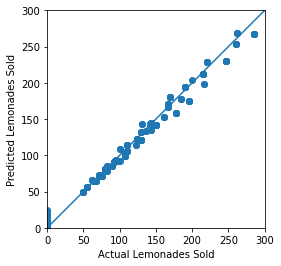

In [18]:
graphPredictions(model, x, y, 0, 300)

## Testing with our Own Predictions
Below we makeup some input data and see what our predictions should be vs what the neural network predicted.

In [19]:
# Below we use the synthetic data generator forumla to
# determine what the actual result should have been.
def datasetGenerator(weekend, sunny, warm, bigsign, price):
    numlemonssold = 0
    if weekend:
        numlemonssold = (sunny*5  + int(500 / price))
        if bigsign:
            numlemonssold = 1.3 * numlemonssold
        if warm:
            numlemonssold = 2 * numlemonssold
        if sunny:
            numlemonssold = 1.25 * numlemonssold
    numlemonssold = int(numlemonssold)    
    return numlemonssold

In [20]:
# Data that affects the number of lemons sold in one day
weekend = 1
sunny = 0
warm = 0   
bigsign = 1
price = 5

# Calculate what would have been the actual result using
# the synthetic dataset's algorithm
actual = datasetGenerator(weekend, sunny, warm, bigsign, price)

# Use the CPU as we just need to do a single pass
model.to('cpu')

# Normalize our inputs using the same values for our training
price = (price - priceMean) / priceStd

# Create our input tensor
x1 = torch.tensor([weekend, sunny, warm, bigsign, price],dtype=float)

# Pass the input into the neural network
y1 = model(x1.float())

# Un-normalize our output y1
y1 = y1*numSoldStd+numSoldMean

# Compare what your network predicted to the actual
print ("Neural Network Predicts: ", y1.item())
print ("Actual Result: ", actual)

Neural Network Predicts:  132.20266723632812
Actual Result:  130
